# Data Analysis "Kickstarter.csv"

In [91]:
!pip install pyspark

## Data Description

o ID : Unique Kickstarter ID                                          
o name : Name of proposal                                                        
o category : Specific category of project                                        
o main_category : Parent Categories                                              
o currency : Original currency                                                  
o deadline : Project expiry date                                                 
o goal : Goal of product in respective currency                                  
o launched : Project launch date                                                 
o pledged : Amount of pledged before deadline                                   
o state : State of project -- fail, success, ...                                 
o backers : Number of backers for a project                                     
o country : Country of project                                                   
o usd pledged : Pledged amount converted to USD (by Kickstarter)                 
o usd_pledged_real : Pledged amount converted to USD (by Fixer.io)               
o usd_goal_real : Goal amount converted to USD (by Fixer.io)

## Imports

In [92]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, count, sum, when, col
from pyspark.ml.feature import Imputer

## Setting up the Spark session

In [93]:
spark = SparkSession.builder \
    .appName("kick_starter-SparkDataFrame") \
    .getOrCreate()

data = spark.read.csv("kick_starter.csv", header=True, inferSchema=True)

### Data Shape

In [94]:
# Get the number of rows and columns
num_rows = data.count()
num_columns = len(data.columns)

# Shape of the DataFrame
data_shape = (num_rows, num_columns)

print("Shape of the DataFrame:", data_shape)

Shape of the DataFrame: (378661, 15)


In [95]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: string (nullable = true)
 |-- goal: string (nullable = true)
 |-- launched: string (nullable = true)
 |-- pledged: string (nullable = true)
 |-- state: string (nullable = true)
 |-- backers: string (nullable = true)
 |-- country: string (nullable = true)
 |-- usd pledged: string (nullable = true)
 |-- usd_pledged_real: string (nullable = true)
 |-- usd_goal_real: string (nullable = true)



In [96]:
data.head(5)

[Row(ID=1000002330, name='The Songs of Adelaide & Abullah', category='Poetry', main_category='Publishing', currency='GBP', deadline='2015-10-09', goal='1000.00', launched='2015-08-11 12:12:28', pledged='0.00', state='failed', backers='0', country='GB', usd pledged='0.00', usd_pledged_real='0.00', usd_goal_real='1533.95'),
 Row(ID=1000003930, name='Greeting From Earth: ZGAC Arts Capsule For ET', category='Narrative Film', main_category='Film & Video', currency='USD', deadline='2017-11-01', goal='30000.00', launched='2017-09-02 04:43:57', pledged='2421.00', state='failed', backers='15', country='US', usd pledged='100.00', usd_pledged_real='2421.00', usd_goal_real='30000.00'),
 Row(ID=1000004038, name='Where is Hank?', category='Narrative Film', main_category='Film & Video', currency='USD', deadline='2013-02-26', goal='45000.00', launched='2013-01-12 00:20:50', pledged='220.00', state='failed', backers='3', country='US', usd pledged='220.00', usd_pledged_real='220.00', usd_goal_real='4500

## Data Processing

### Missing Values

In [97]:
# Calculate missing values
missing_values = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas().head()
print("Missing Values:")
missing_values

Missing Values:


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,0,4,0,3,4,5,5,5,5,5,5,5,3795,12,5


In [98]:
# Handle missing values
data = data.dropna(subset=['name', 'currency'])  # Drop rows with missing values in 'name' and 'currency' columns

# Impute missing values in 'usd pledged' column with mean
usd_pledged_mean = data.select(avg('usd pledged')).collect()[0][0]
data = data.fillna({'usd pledged': usd_pledged_mean})

### Duplicates

In [99]:
# Before removing duplicates
rows_before = data.count()

# Handle duplicates
data = data.dropDuplicates()

# after removing duplicates
rows_after = data.count()

print("Number of rows before removing duplicates:", rows_before)
print("Number of rows after removing duplicates:", rows_after)

Number of rows before removing duplicates: 378653
Number of rows after removing duplicates: 378653


### Incorrect Format

In [100]:
from pyspark.sql.functions import to_timestamp
incorrect_format = data.filter(
    (data["goal"].cast("double").isNull()) |
    (data["pledged"].cast("double").isNull()) |
    (data["backers"].cast("int").isNull()) |
    (data["usd pledged"].cast("double").isNull()) |
    (data["country"].cast("string").isNull()) |
    (data["usd_pledged_real"].cast("double").isNull()) |
    (data["usd_goal_real"].cast("double").isNull())

)
incorrect_format.show(truncate=False)

+----------+---------------------------------------------------+---------------------------------------------------------+---------------+--------------------+----------------+----------+--------+-------------------+-------+-------------------+-------+-----------+----------------+-------------+
|ID        |name                                               |category                                                 |main_category  |currency            |deadline        |goal      |launched|pledged            |state  |backers            |country|usd pledged|usd_pledged_real|usd_goal_real|
+----------+---------------------------------------------------+---------------------------------------------------------+---------------+--------------------+----------------+----------+--------+-------------------+-------+-------------------+-------+-----------+----------------+-------------+
|1060003940|"Help Us Publish ""A Nearly Pretentious Collection | Volume 2""!"                                   

In [101]:
# Count the rows with incorrect format
incorrect_format_count = incorrect_format.count()
print("Count of rows with incorrect format:", incorrect_format_count)

Count of rows with incorrect format: 1293


In [102]:
data = data.exceptAll(incorrect_format)

### Transformation

In [103]:
from pyspark.sql.functions import to_timestamp

# Transformation and type casting
data = data.withColumn("goal", data["goal"].cast("double")) \
           .withColumn("pledged", data["pledged"].cast("double")) \
           .withColumn("backers", data["backers"].cast("int")) \
           .withColumn("usd pledged", data["usd pledged"].cast("double")) \
           .withColumn("country", data["country"].cast("string")) \
           .withColumn("usd_pledged_real", data["usd_pledged_real"].cast("double")) \
           .withColumn("usd_goal_real", data["usd_goal_real"].cast("double")) \
           .withColumn("launched", to_timestamp(data["launched"], "MM/dd/yyyy h:mm:ss a")) \
           .withColumn("deadline", to_timestamp(data["deadline"], "MM/dd/yyyy"))

In [104]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: timestamp (nullable = true)
 |-- goal: double (nullable = true)
 |-- launched: timestamp (nullable = true)
 |-- pledged: double (nullable = true)
 |-- state: string (nullable = true)
 |-- backers: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- usd pledged: double (nullable = true)
 |-- usd_pledged_real: double (nullable = true)
 |-- usd_goal_real: double (nullable = true)



# Data Analysis " Queries " + Visualization

In [105]:
from pyspark.sql.functions import avg, count, sum, when, to_timestamp, datediff, year
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Query 1

### In this query the distrbution of the states of the project on the csv

In [106]:
# Group by the "state" column and count the occurrences
state_distribution = data.groupBy("state").count()

# Show the results
state_distribution.show()


+----------+------+
|     state| count|
+----------+------+
| suspended|  1843|
|    failed|197049|
|  canceled| 38687|
|successful|133429|
|      live|  2796|
| undefined|  3556|
+----------+------+



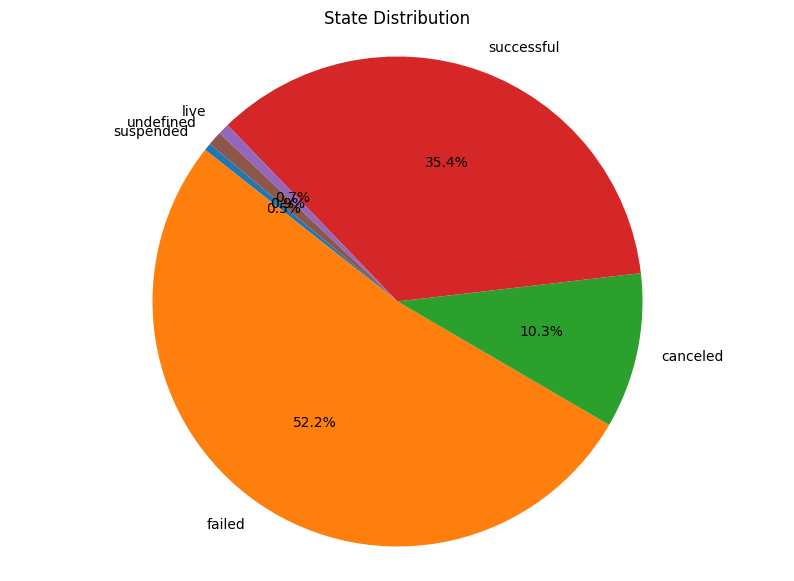

In [107]:
# Convert to Pandas DataFrame for visualization
state_distribution_pd = state_distribution.toPandas()

# Plotting with Matplotlib
plt.figure(figsize=(10, 7))
plt.pie(state_distribution_pd['count'], labels=state_distribution_pd['state'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("State Distribution")
plt.show()

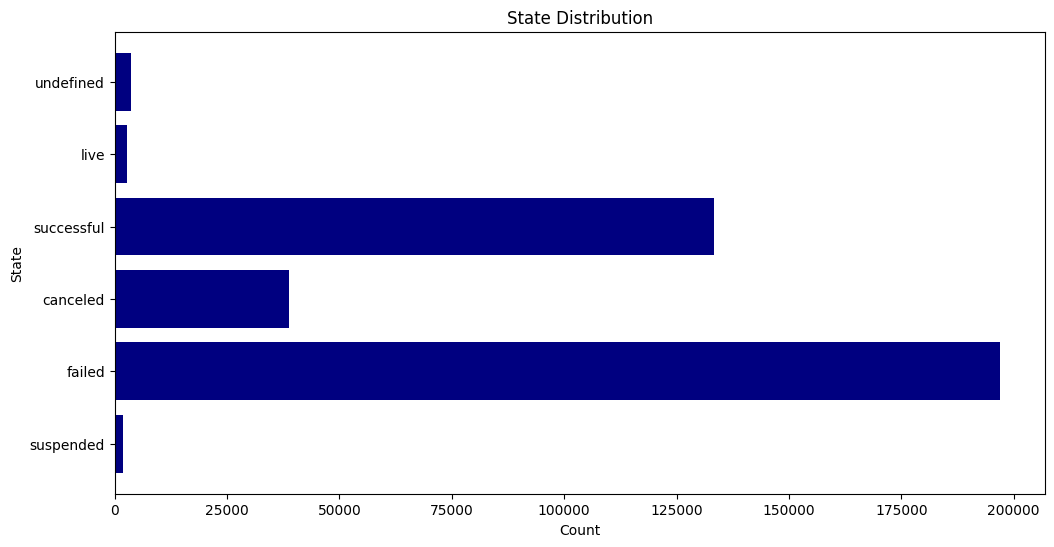

In [108]:
# Plotting with Matplotlib
plt.figure(figsize=(12, 6))
plt.barh(state_distribution_pd['state'], state_distribution_pd['count'], color='navy')
plt.ylabel('State')
plt.xlabel('Count')
plt.title('State Distribution')
plt.show()

Very interesting distribution !
we can see that only 35,38% of all projects got sucess.
More than 60% have failed or canceled.

## Query 2

### In this query We are checking the percentage of successfull and failed projects in each category

In [110]:
# Calculate the total count of projects by category
category_counts = data.groupBy("category").agg(count("*").alias("total_count"))

# Calculate the count of successful projects by category
success_counts = data.filter(data.state == "successful") \
    .groupBy("category").agg(count("*").alias("success_count"))

# Calculate the count of failed projects by category
failure_counts = data.filter(data.state == "failed") \
    .groupBy("category").agg(count("*").alias("failure_count"))

# Join the counts to calculate success and failure rates
rates = category_counts.join(success_counts, "category", "left") \
    .join(failure_counts, "category", "left") \
    .fillna(0)

# Calculate success and failure rates
rates = rates.withColumn("success_rate", rates["success_count"] / rates["total_count"]) \
    .withColumn("failure_rate", rates["failure_count"] / rates["total_count"])

# Get the top 15 categories by total count of projects
top_categories = rates.orderBy("total_count", ascending=False).limit(15)


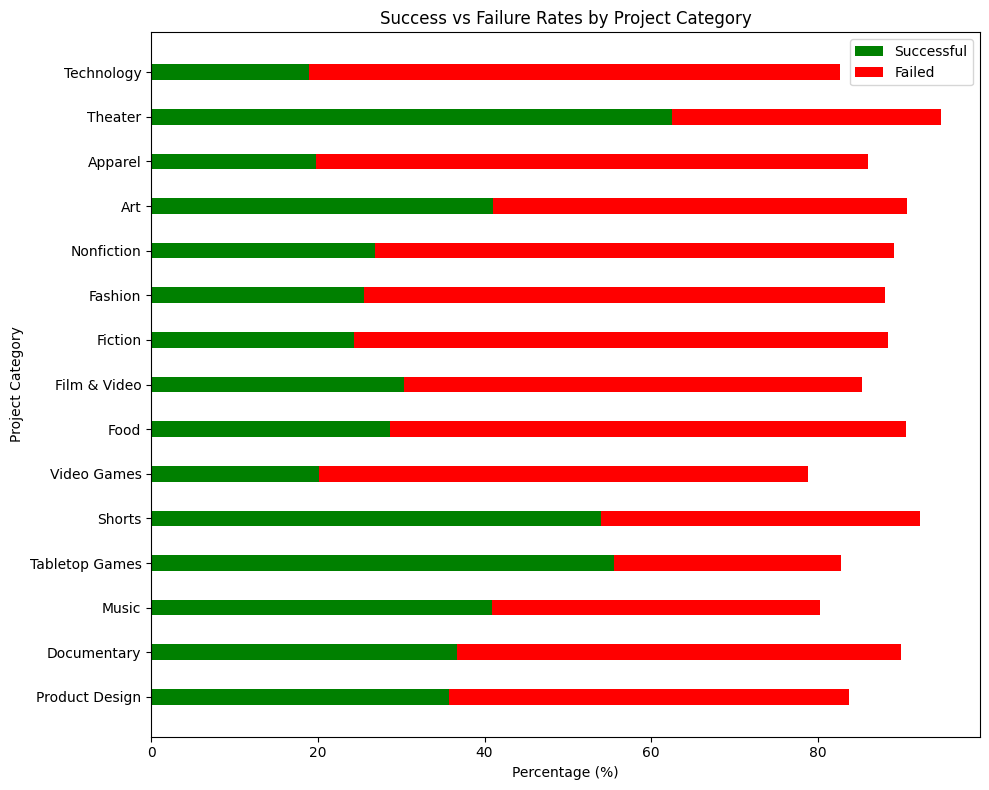

In [111]:
import numpy as np

# Convert Spark DataFrame to Pandas DataFrame for visualization
top_categories_pd = top_categories.toPandas()

# Plotting the bar chart
plt.figure(figsize=(10, 8))

index = np.arange(len(top_categories_pd))  # Using numpy array for indexing
bar_height = 0.35

plt.barh(index, top_categories_pd["success_rate"] * 100, bar_height, label='Successful', color='green')
plt.barh(index, top_categories_pd["failure_rate"] * 100, bar_height, label='Failed', color='red', left=top_categories_pd["success_rate"] * 100)

plt.ylabel('Project Category')
plt.xlabel('Percentage (%)')
plt.title('Success vs Failure Rates by Project Category')
plt.yticks(index, top_categories_pd["category"])
plt.legend()

plt.tight_layout()
plt.show()


Tabletop games ,Theater, and Shorts have the highest success rates and Technology, Appearel, and video games have the lowest.

## Query 3

### What types of projects are being funded?

In [112]:
# Group by project ID, name, category, currency, and usd_pledged_real
grouped_data = data.groupBy("ID", "name", "category", "currency") \
    .agg({"usd_pledged_real": "sum"}) \
    .withColumnRenamed("sum(usd_pledged_real)", "total_usd_pledged_real")

# Sort the projects by total USD pledged amount in descending order
sorted_data = grouped_data.orderBy(col("total_usd_pledged_real").desc())

# Select the top 15 highest funded projects
top_15_projects = sorted_data.limit(15)

# Show the top 15 highest funded projects
top_15_projects.select("ID", "name", "category", "currency", "total_usd_pledged_real").show(truncate=False)

+----------+----------------------------------------------------------+---------------+--------+----------------------+
|ID        |name                                                      |category       |currency|total_usd_pledged_real|
+----------+----------------------------------------------------------+---------------+--------+----------------------+
|1799979574|Pebble Time - Awesome Smartwatch, No Compromises          |Product Design |USD     |2.033898627E7         |
|342886736 |COOLEST COOLER: 21st Century Cooler that's Actually Cooler|Product Design |USD     |1.328522636E7         |
|2103598555|Pebble 2, Time 2 + All-New Pebble Core                    |Product Design |USD     |1.277984349E7         |
|545070200 |Kingdom Death: Monster 1.5                                |Tabletop Games |USD     |1.239313969E7         |
|506924864 |Pebble: E-Paper Watch for iPhone and Android              |Product Design |USD     |1.026684574E7         |
|565687737 |The World's Best TRAVEL JACK

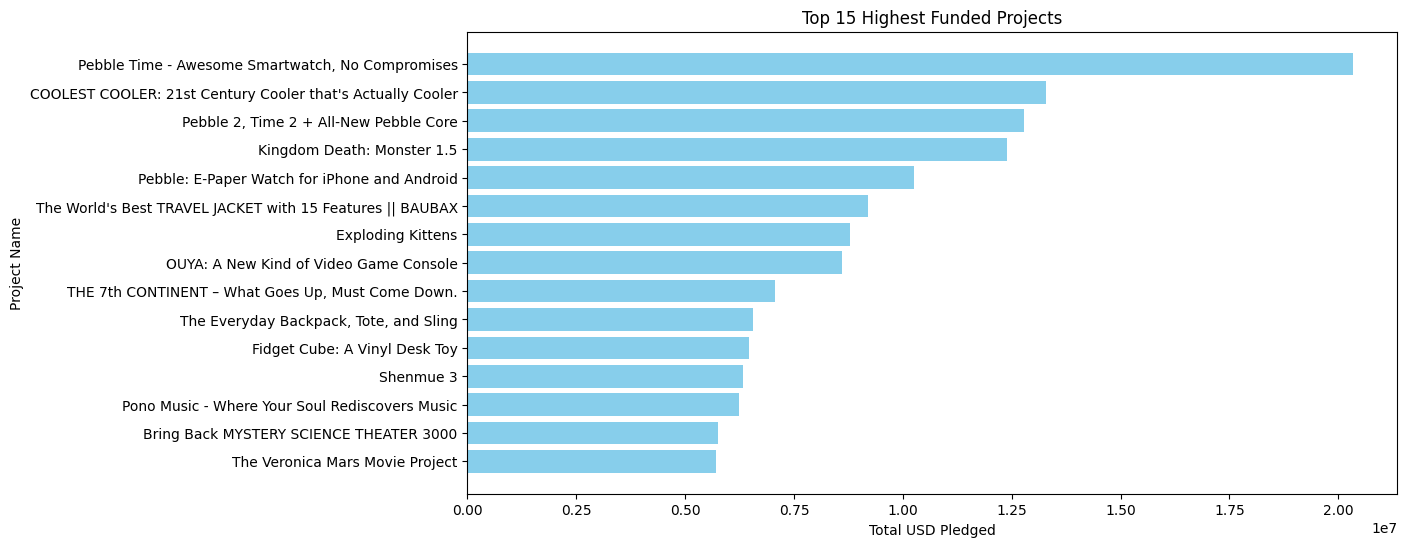

In [113]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
top_15_projects_pd = top_15_projects.toPandas()

# Plotting the top 15 highest funded projects
plt.figure(figsize=(12, 6))
plt.barh(top_15_projects_pd['name'], top_15_projects_pd['total_usd_pledged_real'], color='skyblue')
plt.xlabel('Total USD Pledged')
plt.ylabel('Project Name')
plt.title('Top 15 Highest Funded Projects')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest funded project at the top
plt.show()

A lot of the projects here fall under the Product Design subcategory.

## Query 4

### Top 15 projects with the highest set funding goals.

In [114]:
# Ordering by goal in descending order and selecting the top 15
top_15_ambitious_projects = data.select("ID", "name", "category","state","usd_goal_real") \
    .orderBy("usd_goal_real", ascending=False) \
    .limit(15)

# Show the top 15 most ambitious projects
top_15_ambitious_projects.show(truncate=False)

+----------+------------------------------------------------------------+--------------+--------+--------------+
|ID        |name                                                        |category      |state   |usd_goal_real |
+----------+------------------------------------------------------------+--------------+--------+--------------+
|1243678698|FUCK Potato Salad. Paleo Potato Brownies!                   |Food          |failed  |1.6636139071E8|
|2000749004|A Celtic Lovestory                                          |Drama         |failed  |1.5139586992E8|
|944541075 |Hydroponic's Skyscraper(un gratte-ciel hydroponique)e-solar |Technology    |failed  |1.1016977162E8|
|2132015082|DER NEANDERTALER (Kinofilm mit Starbesetzung in 3D)         |Movie Theaters|failed  |1.0736986772E8|
|219702078 |Kitchen from Austria in Switzerland                         |Restaurants   |failed  |1.0405718983E8|
|388031956 |UniqueTrends                                                |Apparel       |failed  

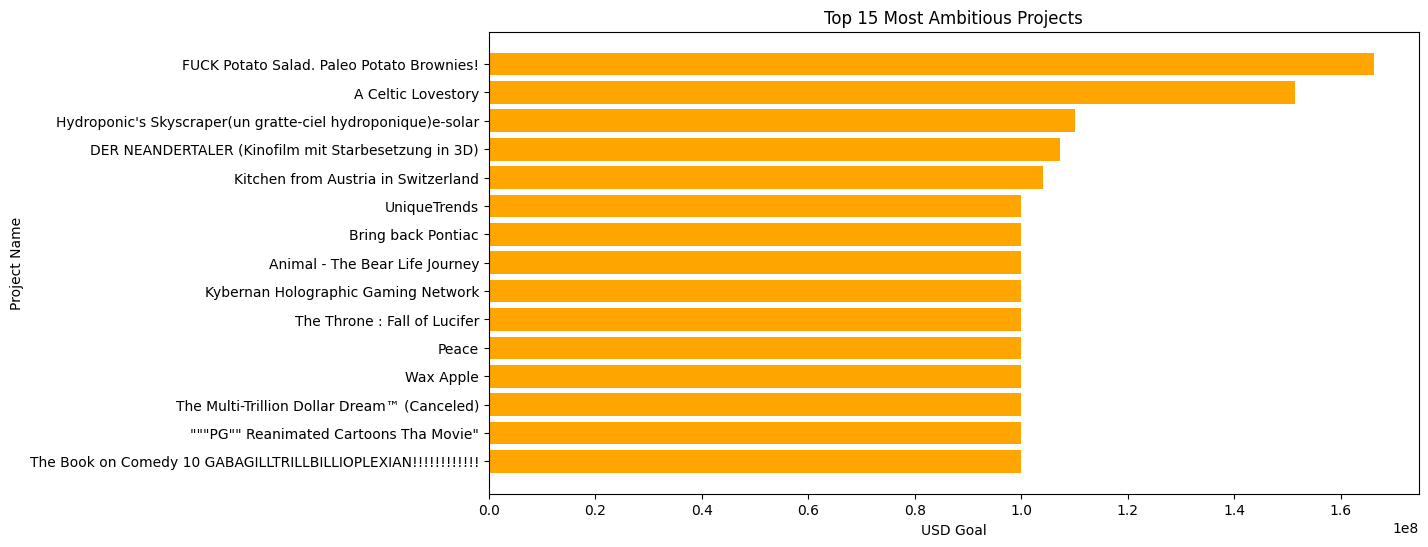

In [115]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
top_15_ambitious_projects_pd = top_15_ambitious_projects.toPandas()

# Plotting the top 15 most ambitious projects
plt.figure(figsize=(12, 6))
plt.barh(top_15_ambitious_projects_pd['name'], top_15_ambitious_projects_pd['usd_goal_real'], color='orange')
plt.xlabel('USD Goal')
plt.ylabel('Project Name')
plt.title('Top 15 Most Ambitious Projects')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest goal project at the top
plt.show()

Aside from the one project that was canceled, all other projects failed here. Their goals must have been set too high and seen as being too unreasonable for the idea they were selling

## Query 5

Here we divide the projects into two different categories, “complete” projects (projects that have reached their deadline, i.e. successful and failed pojects) and “incomplete” projects (projects that have not reached their deadline, i.e. live, cancelled, or suspended projects).

In [116]:
from pyspark.sql.window import Window
from pyspark.sql.functions import when, col, count, lit

# Filter out projects with state as "undefined"
data = data.filter(col("state") != "undefined")

# Categorize projects into "complete" and "incomplete" based on their status
data = data.withColumn("project_group",
                       when((col("state") == "successful") | (col("state") == "failed"), "complete")
                       .otherwise("incomplete"))

# Group by project group and status, and calculate the count of each status
status_counts = data.groupBy("project_group", "state").agg(count("*").alias("status_count"))

# Calculate the proportion of project statuses for each group
proportion = status_counts.withColumn("status_proportion", col("status_count") / sum("status_count").over(Window.partitionBy("project_group")))

# Convert Spark DataFrame to Pandas DataFrame for visualization
proportion_pd = proportion.toPandas()

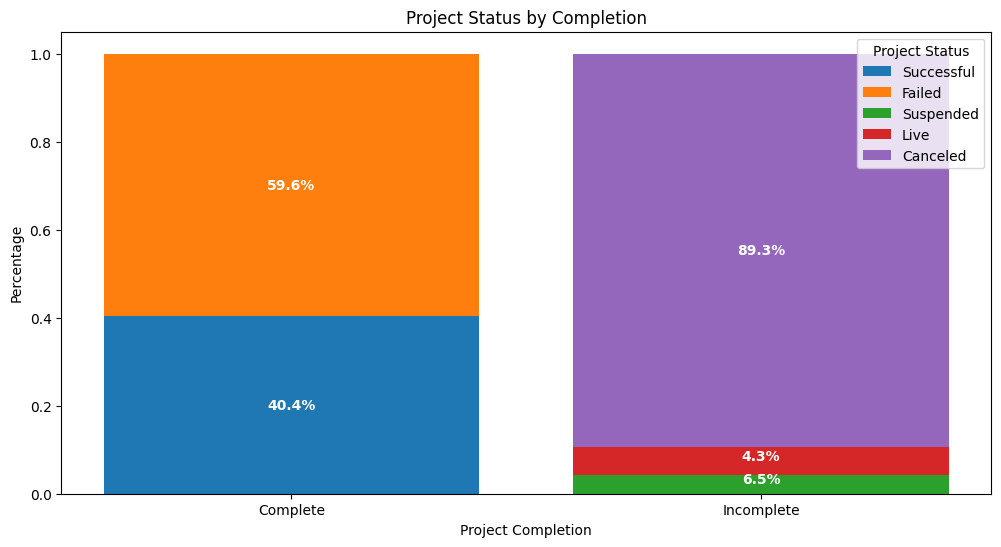

In [117]:
# Plotting with Matplotlib
plt.figure(figsize=(12, 6))

# Create a stacked bar plot
complete = proportion_pd[proportion_pd['project_group'] == 'complete']
incomplete = proportion_pd[proportion_pd['project_group'] == 'incomplete']

categories = proportion_pd['state'].unique()
categories = [c for c in ["successful", "failed", "suspended", "live", "canceled"] if c in categories]

# Plot complete projects
complete_bottoms = None
incomplete_bottoms = None

for category in categories:
    complete_values = complete[complete['state'] == category]['status_proportion'].values
    incomplete_values = incomplete[incomplete['state'] == category]['status_proportion'].values

    if len(complete_values) > 0:
        plt.bar("Complete", complete_values[0], bottom=complete_bottoms, label=category.capitalize())
        if complete_bottoms is None:
            complete_bottoms = complete_values[0]
        else:
            complete_bottoms += complete_values[0]

    if len(incomplete_values) > 0:
        plt.bar("Incomplete", incomplete_values[0], bottom=incomplete_bottoms, label=category.capitalize())
        if incomplete_bottoms is None:
            incomplete_bottoms = incomplete_values[0]
        else:
            incomplete_bottoms += incomplete_values[0]

# Add labels and title
plt.xlabel('Project Completion')
plt.ylabel('Percentage')
plt.title('Project Status by Completion')
plt.xticks([0, 1], ['Complete', 'Incomplete'])
plt.legend(title='Project Status', loc='best')

# Display percentages on bars
complete_bottoms = 0
incomplete_bottoms = 0

for idx, row in proportion_pd.iterrows():
    if row['project_group'] == 'complete':
        plt.text(0, complete_bottoms + row['status_proportion'] / 2, f"{row['status_proportion']*100:.1f}%",
                 ha='center', va='center', color='white', weight='bold')
        complete_bottoms += row['status_proportion']
    elif row['project_group'] == 'incomplete':
        plt.text(1, incomplete_bottoms + row['status_proportion'] / 2, f"{row['status_proportion']*100:.1f}%",
                 ha='center', va='center', color='white', weight='bold')
        incomplete_bottoms += row['status_proportion']

plt.show()

Now we know that approximately 60% of completed projects failed and only approximately 40% succeeded. Approximately 90% of incomplete projects were cancelled.

## Query 6

### In this query checks Average Pledged Amount and Goal Amount by State

In [118]:
# 2. Average pledged amount and goal amount by state
result2 = data.groupBy("state").agg(avg("pledged").alias("avg_pledged"), avg("goal").alias("avg_goal")) \
             .limit(5)
result2.show()
pd_result2 = result2.toPandas()

+----------+------------------+-----------------+
|     state|       avg_pledged|         avg_goal|
+----------+------------------+-----------------+
| suspended|10833.980803038523|181649.2083559414|
|    failed|1429.0772380981334|67486.64871575088|
|  canceled|2649.8883767156913|86285.00377697934|
|successful| 24163.56535288418|10178.61354270811|
|      live| 9078.974660228898|76751.40879828326|
+----------+------------------+-----------------+



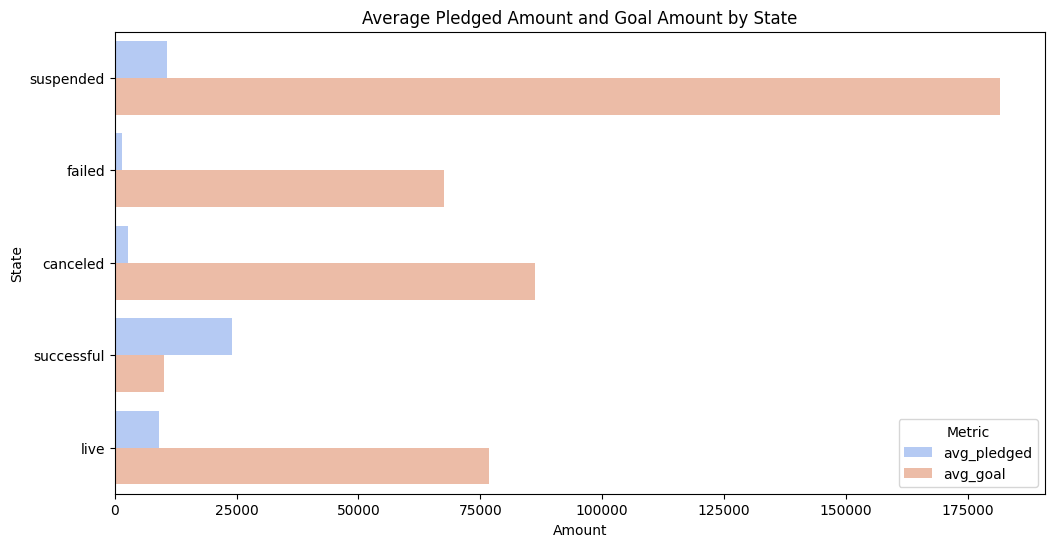

In [119]:
# 2. Bar Plot: Average Pledged Amount and Goal Amount by State
plt.figure(figsize=(12, 6))
pd_result2_melted = pd_result2.melt(id_vars='state', value_vars=['avg_pledged', 'avg_goal'], var_name='Metric', value_name='Amount')
sns.barplot(x='Amount', y='state', hue='Metric', data=pd_result2_melted, palette='coolwarm')
plt.title('Average Pledged Amount and Goal Amount by State')
plt.xlabel('Amount')
plt.ylabel('State')
plt.legend(title='Metric')
plt.show()

AS you can see the key for successfull project is avg pledged more than the average goal.

## Query 7

### In this query we are checking the average goal in each category

In [120]:
# Group by main_category and calculate the sum of usd_goal_real and count of projects
goal_avg = data.groupBy('main_category').agg(
    sum('usd_goal_real').alias('goal'),
    count('*').alias('projects')
)

# Calculate average goal per category
goal_avg = goal_avg.withColumn('avg', col('goal') / col('projects'))

# Convert to Pandas DataFrame for further processing and plotting
goal_avg_pd = goal_avg.toPandas()

# Sort by average goal in descending order
goal_avg_pd = goal_avg_pd.sort_values(by='avg', ascending=False)

# Convert main_category to categorical type with specified order
goal_avg_pd['main_category'] = pd.Categorical(goal_avg_pd['main_category'], categories=goal_avg_pd['main_category'], ordered=True)

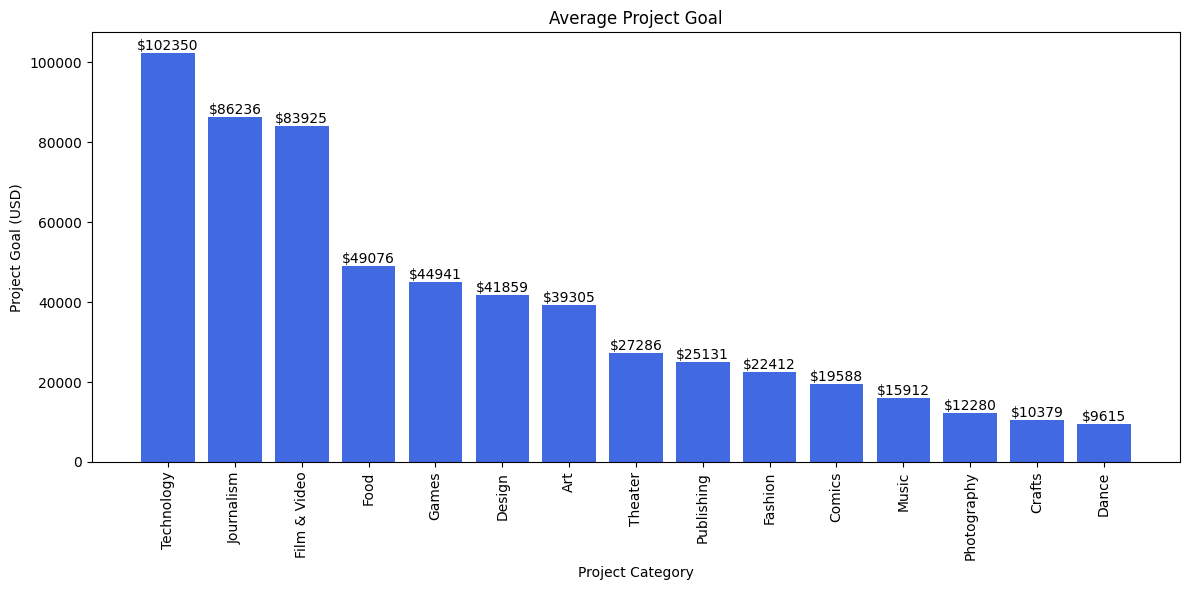

In [121]:
# Plotting with Matplotlib
plt.figure(figsize=(12, 6))
plt.bar(goal_avg_pd['main_category'], goal_avg_pd['avg'], color='royalblue')
plt.xlabel('Project Category')
plt.ylabel('Project Goal (USD)')
plt.title('Average Project Goal')
plt.xticks(rotation=90)
plt.tight_layout()

# Add labels on top of the bars
for index, value in enumerate(goal_avg_pd['avg']):
    plt.text(index, value, f'${value:.0f}', ha='center', va='bottom')

# Show the plot
plt.show()

Technology, Journalism, and Film & Video have the highest average project goals by far. On the opposite side, we find Dance, Crafts, and Photography.

## Query 8

In [122]:
# 4. Total amount pledged by main category
result4 = data.groupBy("main_category").agg(sum("pledged").alias("total_pledged")) \
             .orderBy("total_pledged", ascending=False) \
             .limit(5)
result4.show()
pd_result4 = result4.toPandas()

+-------------+-------------------+
|main_category|      total_pledged|
+-------------+-------------------+
|       Design|8.152761994600008E8|
|        Games|7.702414513899992E8|
|   Technology|7.351549951399996E8|
| Film & Video|4.018086091699997E8|
|        Music|1.997086332799992E8|
+-------------+-------------------+



<ipython-input-123-97571dbf7686>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_pledged', y='main_category', data=pd_result4, palette='magma')


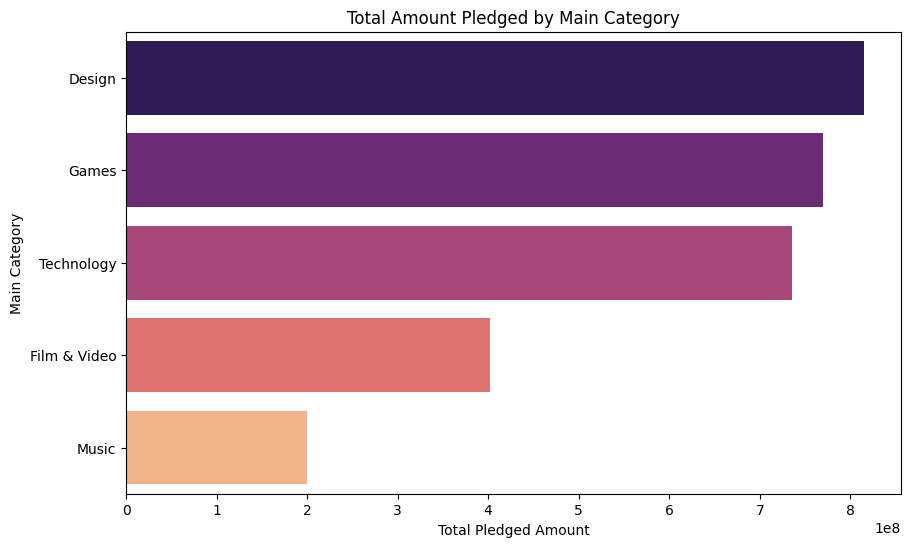

In [123]:
# 4. Bar Plot: Total Amount Pledged by Main Category
plt.figure(figsize=(10, 6))
sns.barplot(x='total_pledged', y='main_category', data=pd_result4, palette='magma')
plt.title('Total Amount Pledged by Main Category')
plt.xlabel('Total Pledged Amount')
plt.ylabel('Main Category')
plt.show()

## Query 9

### In this query we are checking the country that has the most Backers

In [124]:
# 5. Number of backers by country
result5 = data.groupBy("country").agg(sum("backers").alias("total_backers")) \
             .orderBy("total_backers", ascending=False) \
             .limit(5)
result5.show()
pd_result5 = result5.toPandas()

+-------+-------------+
|country|total_backers|
+-------+-------------+
|     US|     33041203|
|     GB|      2858375|
|     CA|      1302057|
|     AU|       642197|
|     DE|       409912|
+-------+-------------+



<ipython-input-125-3030160ebff2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_backers', y='country', data=pd_result5, palette='Greens')


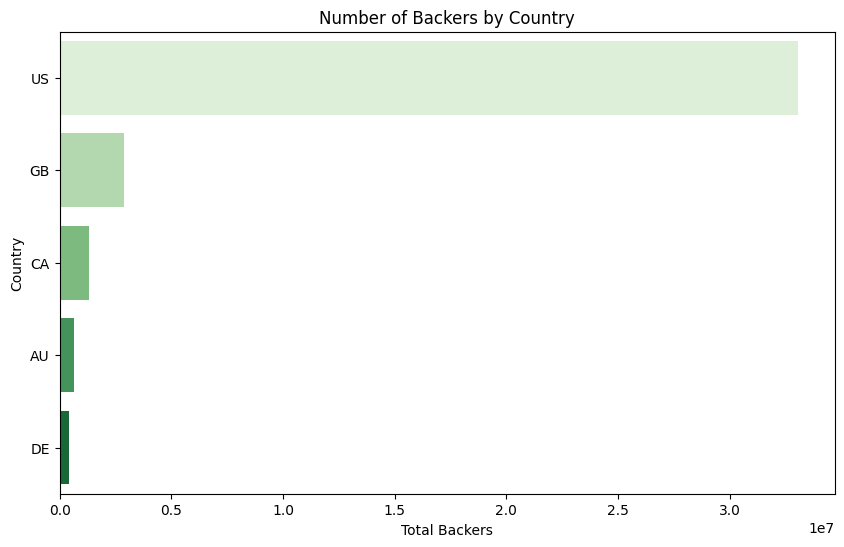

In [125]:
# 5. Bar Plot: Number of Backers by Country
plt.figure(figsize=(10, 6))
sns.barplot(x='total_backers', y='country', data=pd_result5, palette='Greens')
plt.title('Number of Backers by Country')
plt.xlabel('Total Backers')
plt.ylabel('Country')
plt.show()

Turns Out to be USA

## Query 10

### Total Amount of projects of each category

In [126]:
# 1. Total count of projects by main category
result1 = data.groupBy("main_category").agg(count("*").alias("total_projects")) \
             .orderBy("total_projects", ascending=False) \
             .limit(5)
result1.show()
pd_result1 = result1.toPandas()

+-------------+--------------+
|main_category|total_projects|
+-------------+--------------+
| Film & Video|         62450|
|        Music|         49398|
|   Publishing|         39165|
|        Games|         35200|
|   Technology|         32527|
+-------------+--------------+



<ipython-input-127-f81bfdaa56c6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_projects', y='main_category', data=pd_result1, palette='viridis')


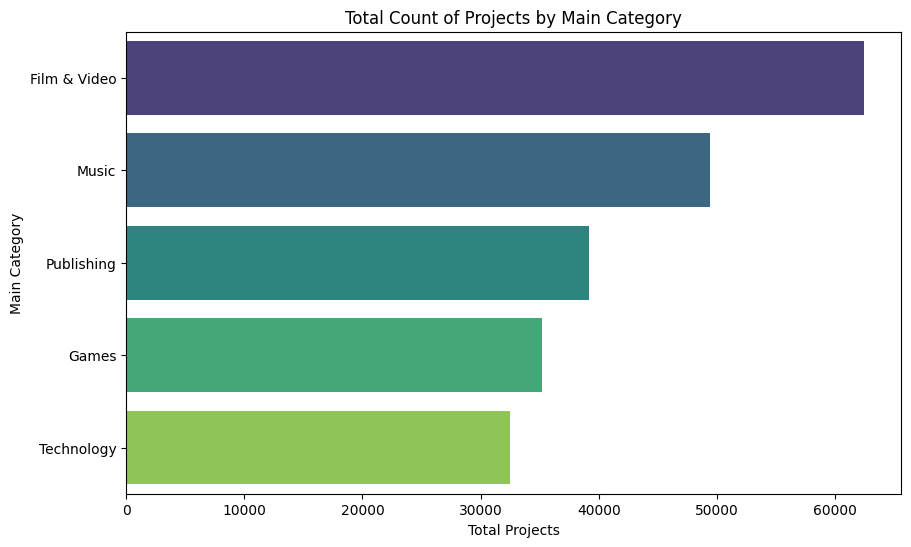

In [127]:
# 1. Bar Plot: Total Count of Projects by Main Category
plt.figure(figsize=(10, 6))
sns.barplot(x='total_projects', y='main_category', data=pd_result1, palette='viridis')
plt.title('Total Count of Projects by Main Category')
plt.xlabel('Total Projects')
plt.ylabel('Main Category')
plt.show()

# ML MODELS

## Preparing Data for Machine Learning

In [128]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler

data = data.filter(col("state") != "live")
data = data.withColumn("label", when(col("state") == "successful", 1).otherwise(0))

feature_columns = ["goal", "pledged", "backers", "usd pledged", "usd_pledged_real", "usd_goal_real"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

data = data.select("features", "label")

In [129]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

## Training models and calculating accuracy

## LogisticRegression

In [130]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

## DecisionTreeClassifier

In [131]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

## RandomForestClassifier

In [132]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

## Evaluation

In [134]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label")

lr_accuracy = evaluator.evaluate(lr_predictions)
dt_accuracy = evaluator.evaluate(dt_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")


Logistic Regression Accuracy: 0.9966797344510896
Decision Tree Accuracy: 0.9834852886522076
Random Forest Accuracy: 0.9960350854092616


## Confusion matrix

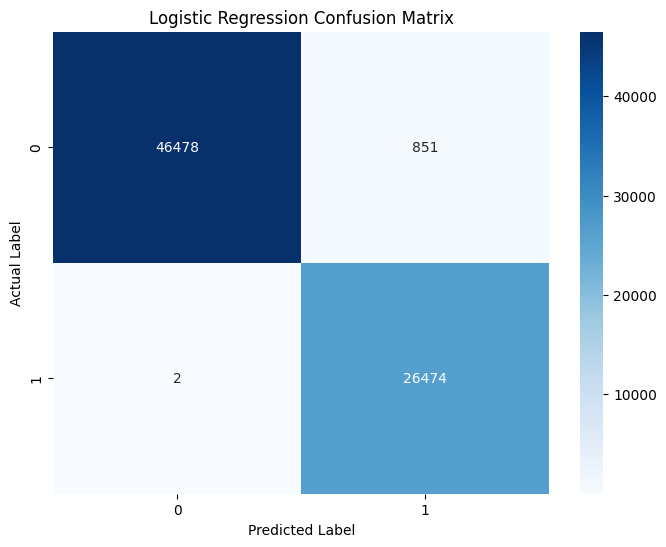

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Extracting true labels and predicted labels
true_labels = np.array(lr_predictions.select("label").rdd.flatMap(lambda x: x).collect())
pred_labels = np.array(lr_predictions.select("prediction").rdd.flatMap(lambda x: x).collect())

# Computing the confusion matrix
confusion_matrix = MulticlassMetrics(zip(pred_labels, true_labels)).confusionMatrix().toArray()

# Plot confusion matrix for Logistic Regression model
plot_confusion_matrix(confusion_matrix, "Logistic Regression")
